In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")


## Extracting Amazon stock dataset using yfinance
data = yf.download("AMZN", start="1997-05-15", end="2023-04-05")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [72]:
## assigning availale device to a variable

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [73]:
## Total length of the datasets

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 1997-05-15 to 2023-04-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6515 non-null   float64
 1   High       6515 non-null   float64
 2   Low        6515 non-null   float64
 3   Close      6515 non-null   float64
 4   Adj Close  6515 non-null   float64
 5   Volume     6515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 356.3 KB


In [74]:
## Creating a subset of the dataset

data = data[['Close']]
data.head()

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354


In [75]:
import plotly.express as px

fig = px.line(x=data.index, y=data['Close'], title='Overall Trends for Closing Stocks value - Amazon')
fig.show();

In [76]:
## preparing dataframe for LSTM

def prepare_dataframe(data, n_steps):

    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(periods=i)

    data.dropna(inplace=True)

    return data


steps = 7

shifted_data = prepare_dataframe(data=data, n_steps=steps)
shifted_data

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-29,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001,97.709999
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997


In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

scaled_data = scaler.fit_transform(shifted_data)
scaled_data

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.10690997,  0.09307615,  0.07431453, ...,  0.05158   ,
         0.05779984,  0.05769258],
       [ 0.09747298,  0.10690997,  0.09308122, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747298,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ]])

In [78]:
X = scaled_data[:, 1:]
y = scaled_data[:, 0]

X.shape, y.shape

((6508, 7), (6508,))

In [79]:
X = np.flip(X, axis=1)
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05769258,  0.05779984,  0.05158   , ...,  0.04203581,
         0.07431453,  0.09307615],
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308122,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308122,
         0.10691495,  0.09747298]])

In [80]:
split_idx = int(len(X) * 0.90) ## Taking 90% for train & 10% for test
split_idx

X_train = X[:split_idx]
X_test = X[split_idx:]

y_train = y[:split_idx]
y_test = y[split_idx:]


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5857, 7), (651, 7), (5857,), (651,))

In [81]:
## PyTorch required to make data in extra dimension

## reshaping the data
X_train = X_train.reshape((-1, steps, 1))
X_test = X_test.reshape((-1, steps, 1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5857, 7, 1), (651, 7, 1), (5857, 1), (651, 1))

In [82]:
X_train = torch.tensor(X_train.copy()).float()
y_train = torch.tensor(y_train.copy()).float()
X_test = torch.tensor(X_test.copy()).float()
y_test = torch.tensor(y_test.copy()).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5857, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5857, 1]),
 torch.Size([651, 1]))

In [83]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [84]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [86]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [87]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [88]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {num_epochs + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [89]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [90]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 11
Batch 100, Loss: 0.853
Batch 200, Loss: 0.483
Batch 300, Loss: 0.275

Val Loss: 0.942
***************************************************

Epoch: 11
Batch 100, Loss: 0.058
Batch 200, Loss: 0.030
Batch 300, Loss: 0.017

Val Loss: 0.558
***************************************************

Epoch: 11
Batch 100, Loss: 0.011
Batch 200, Loss: 0.010
Batch 300, Loss: 0.006

Val Loss: 0.407
***************************************************

Epoch: 11
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.007

Val Loss: 0.272
***************************************************

Epoch: 11
Batch 100, Loss: 0.003
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003

Val Loss: 0.152
***************************************************

Epoch: 11
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.083
***************************************************

Epoch: 11
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.044
**********

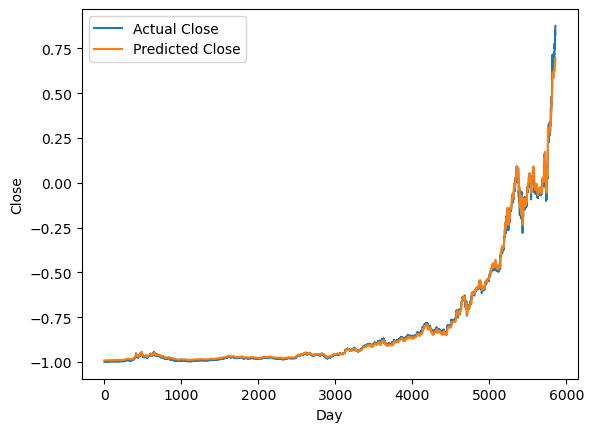

In [91]:
import plotly.graph_objects as go

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [92]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], steps+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dummies[:, 0]
train_predictions

array([  0.89741483,   0.89651441,   0.8959586 , ..., 157.31838291,
       157.59752297, 158.15321299])

In [94]:
dummies = np.zeros((X_train.shape[0], steps+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dummies[:, 0]
new_y_train

array([7.91646240e-02, 7.65634224e-02, 7.52572635e-02, ...,
       1.70089994e+02, 1.72548001e+02, 1.74955992e+02])

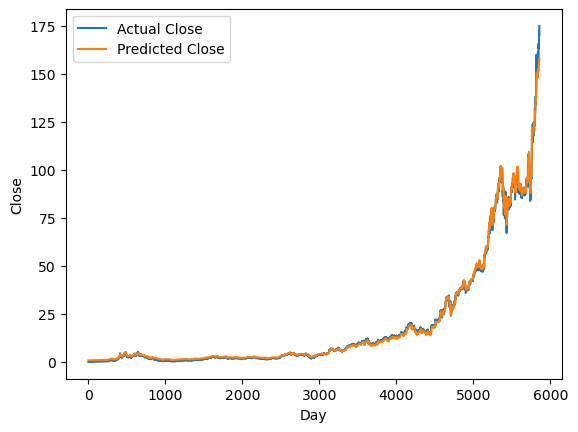

In [95]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [97]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], steps+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dummies[:, 0]
test_predictions

array([158.85925581, 159.5174543 , 158.78745042, 157.73452514,
       155.84217321, 155.51465525, 154.36253971, 152.96706175,
       151.88395031, 151.74936036, 150.90761041, 149.67800908,
       148.18190686, 147.25380035, 148.49491812, 147.89432401,
       147.72672993, 148.51586112, 149.89629324, 150.53498272,
       151.0028155 , 151.95578905, 151.72538817, 152.27898835,
       151.62883246, 152.08676622, 152.34226202, 153.38806734,
       155.36801529, 156.67671983, 156.90445837, 156.94524388,
       156.41273678, 155.47820508, 154.83853737, 154.00311257,
       153.34316882, 153.19255481, 153.12921443, 153.84840777,
       153.23725323, 153.2952578 , 151.66453229, 150.19882744,
       149.60219628, 151.10611322, 152.77890817, 153.85502749,
       153.09763318, 151.66726688, 151.71349379, 151.34990361,
       151.13558795, 150.9833454 , 150.9705895 , 150.76889633,
       150.80596901, 150.58915219, 150.44221209, 150.52961914,
       151.25188611, 151.82697955, 151.97487009, 152.58

In [98]:
dummies = np.zeros((X_test.shape[0], steps+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dummies[:, 0]
new_y_test

array([176.5724938 , 168.39999638, 164.73100153, 157.492002  ,
       163.43049522, 158.75549121, 155.81100326, 155.14849722,
       157.80650284, 153.90500058, 150.43649278, 147.74549971,
       148.02350035, 156.44949265, 149.99299347, 150.9895038 ,
       154.75649947, 158.70250006, 157.24400411, 157.43649302,
       161.06300158, 156.25000049, 159.96000874, 154.99799992,
       159.78449988, 159.52749783, 164.33250634, 172.14649926,
       172.18150432, 168.18550286, 166.93249627, 163.63549548,
       160.36050485, 160.85049231, 159.24699603, 158.8200099 ,
       160.22000106, 160.35200648, 164.31649895, 158.13900643,
       160.55050929, 151.80749277, 150.22400018, 152.42050372,
       162.0580001 , 166.10000615, 165.56849396, 157.18699444,
       151.75100556, 156.86950889, 155.51400495, 156.44050516,
       156.55299601, 156.78300226, 155.27299362, 155.85099951,
       154.97000366, 154.91949699, 155.90300131, 159.25349348,
       159.76699735, 158.40199458, 161.00399655, 160.17

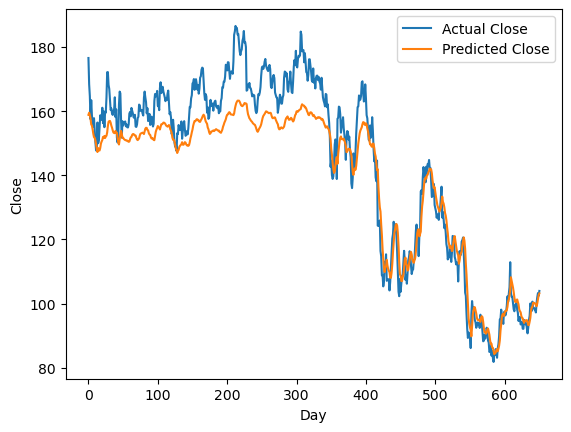

In [99]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()